2024-11-13 15:05:59.876463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:05:59.879191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:05:59.880983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-11-13 15:06:00.091100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:06:00.125519: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-11-13 15:06:00.280352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:06:00.282869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an err

48/48 [==============================] - ETA: 0s - loss: 3.4474 - mae: 1.1148

2024-11-13 15:06:03.530528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:06:03.647488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:06:03.648137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

48/48 [==============================] - 4s 33ms/step - loss: 3.4474 - mae: 1.1148 - val_loss: 1.9219 - val_mae: 0.4976
Epoch 2/20
48/48 [==============================] - 1s 21ms/step - loss: 2.1576 - mae: 0.8359 - val_loss: 1.8086 - val_mae: 0.5563
Epoch 3/20
48/48 [==============================] - 1s 21ms/step - loss: 1.9634 - mae: 0.7816 - val_loss: 1.7271 - val_mae: 0.5176
Epoch 4/20
48/48 [==============================] - 1s 22ms/step - loss: 1.8425 - mae: 0.7448 - val_loss: 1.6676 - val_mae: 0.5138
Epoch 5/20
48/48 [==============================] - 1s 24ms/step - loss: 1.7723 - mae: 0.7237 - val_loss: 1.6285 - val_mae: 0.5153
Epoch 6/20
48/48 [==============================] - 1s 22ms/step - loss: 1.7030 - mae: 0.6923 - val_loss: 1.6010 - val_mae: 0.4940
Epoch 7/20
48/48 [==============================] - 1s 22ms/step - loss: 1.6424 - mae: 0.6711 - val_loss: 1.5779 - val_mae: 0.4765
Epoch 8/20
48/48 [==============================] - 1s 22ms/step - loss: 1.6069 - mae: 0.6543 

2024-11-13 15:06:23.914934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:06:24.007765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:06:24.221225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradient

12/12 [==============================] - 1s 4ms/step


2024-11-13 15:06:24.589061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:06:24.590822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:06:24.591873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-11-13 15:06:24.709802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:06:24.827056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:06:24.829027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

47/48 [============================>.] - ETA: 0s - loss: 4.4653 - mae: 1.2608

2024-11-13 15:06:28.698002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:06:28.829597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:06:28.831380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

48/48 [==============================] - 5s 36ms/step - loss: 4.4284 - mae: 1.2559 - val_loss: 2.0825 - val_mae: 0.6829
Epoch 2/20
48/48 [==============================] - 1s 17ms/step - loss: 2.2954 - mae: 0.8985 - val_loss: 1.7284 - val_mae: 0.5683
Epoch 3/20
48/48 [==============================] - 1s 21ms/step - loss: 2.0622 - mae: 0.8161 - val_loss: 1.6068 - val_mae: 0.5412
Epoch 4/20
48/48 [==============================] - 1s 21ms/step - loss: 1.9331 - mae: 0.7651 - val_loss: 1.5203 - val_mae: 0.5044
Epoch 5/20
48/48 [==============================] - 1s 21ms/step - loss: 1.7886 - mae: 0.7209 - val_loss: 1.4687 - val_mae: 0.4772
Epoch 6/20
48/48 [==============================] - 1s 24ms/step - loss: 1.6748 - mae: 0.6806 - val_loss: 1.4272 - val_mae: 0.5005
Epoch 7/20
48/48 [==============================] - 1s 21ms/step - loss: 1.6621 - mae: 0.6560 - val_loss: 1.3964 - val_mae: 0.4910
Epoch 8/20
48/48 [==============================] - 1s 21ms/step - loss: 1.6303 - mae: 0.6453 

2024-11-13 15:06:48.886212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Fold 6 - Validation MAE: 0.4665590524673462


2024-11-13 15:06:49.131652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:06:49.253496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:06:49.255148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

 1/12 [=>............................] - ETA: 4s

2024-11-13 15:06:49.373462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:06:49.375704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:06:49.377116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 0s 4ms/step


2024-11-13 15:06:49.697940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:06:49.700001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:06:49.701384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-11-13 15:06:49.841522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:06:49.991085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:06:49.993094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

46/48 [===========================>..] - ETA: 0s - loss: 4.1716 - mae: 1.2147

2024-11-13 15:06:53.069998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:06:53.184201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:06:53.185437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

48/48 [==============================] - 4s 29ms/step - loss: 4.1376 - mae: 1.2083 - val_loss: 1.8591 - val_mae: 0.5379
Epoch 2/20
48/48 [==============================] - 1s 25ms/step - loss: 2.1718 - mae: 0.8383 - val_loss: 1.7278 - val_mae: 0.5158
Epoch 3/20
48/48 [==============================] - 1s 21ms/step - loss: 1.9752 - mae: 0.7889 - val_loss: 1.6429 - val_mae: 0.5081
Epoch 4/20
48/48 [==============================] - 1s 21ms/step - loss: 1.8824 - mae: 0.7596 - val_loss: 1.5909 - val_mae: 0.5118
Epoch 5/20
48/48 [==============================] - 1s 20ms/step - loss: 1.7438 - mae: 0.7144 - val_loss: 1.5402 - val_mae: 0.4659
Epoch 6/20
48/48 [==============================] - 1s 21ms/step - loss: 1.6708 - mae: 0.6880 - val_loss: 1.5256 - val_mae: 0.5069
Epoch 7/20
48/48 [==============================] - 1s 21ms/step - loss: 1.6158 - mae: 0.6640 - val_loss: 1.4988 - val_mae: 0.4935
Epoch 8/20
48/48 [==============================] - 1s 21ms/step - loss: 1.6291 - mae: 0.6580 

2024-11-13 15:07:13.439879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:07:13.539950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:07:13.723224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradient

12/12 [==============================] - 1s 4ms/step


2024-11-13 15:07:14.142867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:07:14.145608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:07:14.146712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-11-13 15:07:14.275395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:07:14.417168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:07:14.419511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

48/48 [==============================] - ETA: 0s - loss: 3.6008 - mae: 1.1219

2024-11-13 15:07:17.825294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:07:17.953178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:07:17.954945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

48/48 [==============================] - 4s 39ms/step - loss: 3.6008 - mae: 1.1219 - val_loss: 1.7146 - val_mae: 0.5016
Epoch 2/20
48/48 [==============================] - 1s 23ms/step - loss: 2.2507 - mae: 0.8722 - val_loss: 1.5868 - val_mae: 0.4909
Epoch 3/20
48/48 [==============================] - 1s 21ms/step - loss: 1.9586 - mae: 0.7991 - val_loss: 1.5145 - val_mae: 0.4838
Epoch 4/20
48/48 [==============================] - 1s 15ms/step - loss: 1.8639 - mae: 0.7610 - val_loss: 1.4471 - val_mae: 0.4619
Epoch 5/20
48/48 [==============================] - 1s 19ms/step - loss: 1.7835 - mae: 0.7337 - val_loss: 1.4087 - val_mae: 0.4448
Epoch 6/20
48/48 [==============================] - 1s 25ms/step - loss: 1.7305 - mae: 0.6973 - val_loss: 1.4323 - val_mae: 0.5301
Epoch 7/20
48/48 [==============================] - 1s 26ms/step - loss: 1.6276 - mae: 0.6711 - val_loss: 1.3592 - val_mae: 0.4281
Epoch 8/20
48/48 [==============================] - 1s 22ms/step - loss: 1.5865 - mae: 0.6437 

2024-11-13 15:07:39.759430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:07:39.877006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:07:40.014094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradient

 1/12 [=>............................] - ETA: 9s

2024-11-13 15:07:40.592696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:07:40.593635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:07:40.595427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 1s 2ms/step


2024-11-13 15:07:40.922565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:07:40.924354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:07:40.924918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-11-13 15:07:41.202761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:07:41.403541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:07:41.416229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

48/48 [==============================] - ETA: 0s - loss: 4.1564 - mae: 1.1865

2024-11-13 15:07:44.839414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:07:45.037740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:07:45.039674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

48/48 [==============================] - 4s 40ms/step - loss: 4.1564 - mae: 1.1865 - val_loss: 1.6484 - val_mae: 0.5431
Epoch 2/20
48/48 [==============================] - 2s 41ms/step - loss: 2.2234 - mae: 0.8657 - val_loss: 1.4885 - val_mae: 0.4842
Epoch 3/20
48/48 [==============================] - 1s 21ms/step - loss: 2.0319 - mae: 0.8194 - val_loss: 1.3887 - val_mae: 0.4499
Epoch 4/20
48/48 [==============================] - 1s 19ms/step - loss: 1.8913 - mae: 0.7624 - val_loss: 1.3411 - val_mae: 0.4627
Epoch 5/20
48/48 [==============================] - 1s 23ms/step - loss: 1.8171 - mae: 0.7296 - val_loss: 1.2914 - val_mae: 0.4403
Epoch 6/20
48/48 [==============================] - 1s 23ms/step - loss: 1.7427 - mae: 0.7092 - val_loss: 1.2598 - val_mae: 0.4297
Epoch 7/20
48/48 [==============================] - 1s 22ms/step - loss: 1.6894 - mae: 0.6824 - val_loss: 1.2340 - val_mae: 0.4385
Epoch 8/20
48/48 [==============================] - 1s 23ms/step - loss: 1.6430 - mae: 0.6564 

2024-11-13 15:08:08.026135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:08:08.214652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Fold 9 - Validation MAE: 0.4142918884754181


2024-11-13 15:08:08.325548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:08:08.327412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:08:08.328829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 0s 4ms/step

Average MAE across folds: 0.4563
Average RMSE across folds: 1.1084
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 21, 50)            8400      
                                                                 
 dropout_8 (Dropout)         (None, 21, 50)            0         
                                                                 
 gru_9 (GRU)                 (None, 20)                4320      
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 84        
                                                                 
Total params: 12,804
Trainable params: 12,804
Non-trainable param

2024-11-13 15:08:08.721633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-11-13 15:08:08.834701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:08:08.836555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

60/60 [==============================] - 4s 22ms/step - loss: 1.3677 - mae: 0.5127
Epoch 2/50
60/60 [==============================] - 1s 21ms/step - loss: 1.3669 - mae: 0.5155
Epoch 3/50
60/60 [==============================] - 2s 27ms/step - loss: 1.3557 - mae: 0.5006
Epoch 4/50
60/60 [==============================] - 1s 21ms/step - loss: 1.3639 - mae: 0.5017
Epoch 5/50
60/60 [==============================] - 1s 21ms/step - loss: 1.3432 - mae: 0.4963
Epoch 6/50
60/60 [==============================] - 1s 20ms/step - loss: 1.3379 - mae: 0.4977
Epoch 7/50
60/60 [==============================] - 1s 21ms/step - loss: 1.3324 - mae: 0.4969
Epoch 8/50
60/60 [==============================] - 1s 17ms/step - loss: 1.3446 - mae: 0.4952
Epoch 9/50
60/60 [==============================] - 1s 21ms/step - loss: 1.3682 - mae: 0.4976
Epoch 10/50
60/60 [==============================] - 1s 21ms/step - loss: 1.3748 - mae: 0.5033
Epoch 11/50
60/60 [==============================] - 1s 21ms/step - lo

2024-11-13 15:09:15.804174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-13 15:09:15.808941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-13 15:09:15.810433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 12ms/step


/var/folders/j3/kwprsg3s3_zf9_90gxwcknm00000gn/T/ipykernel_82076/1986943310.py:147: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_dates = pd.date_range(start=data['DATETIME'].max() + pd.Timedelta(hours=8), periods=n_future, freq='8H')


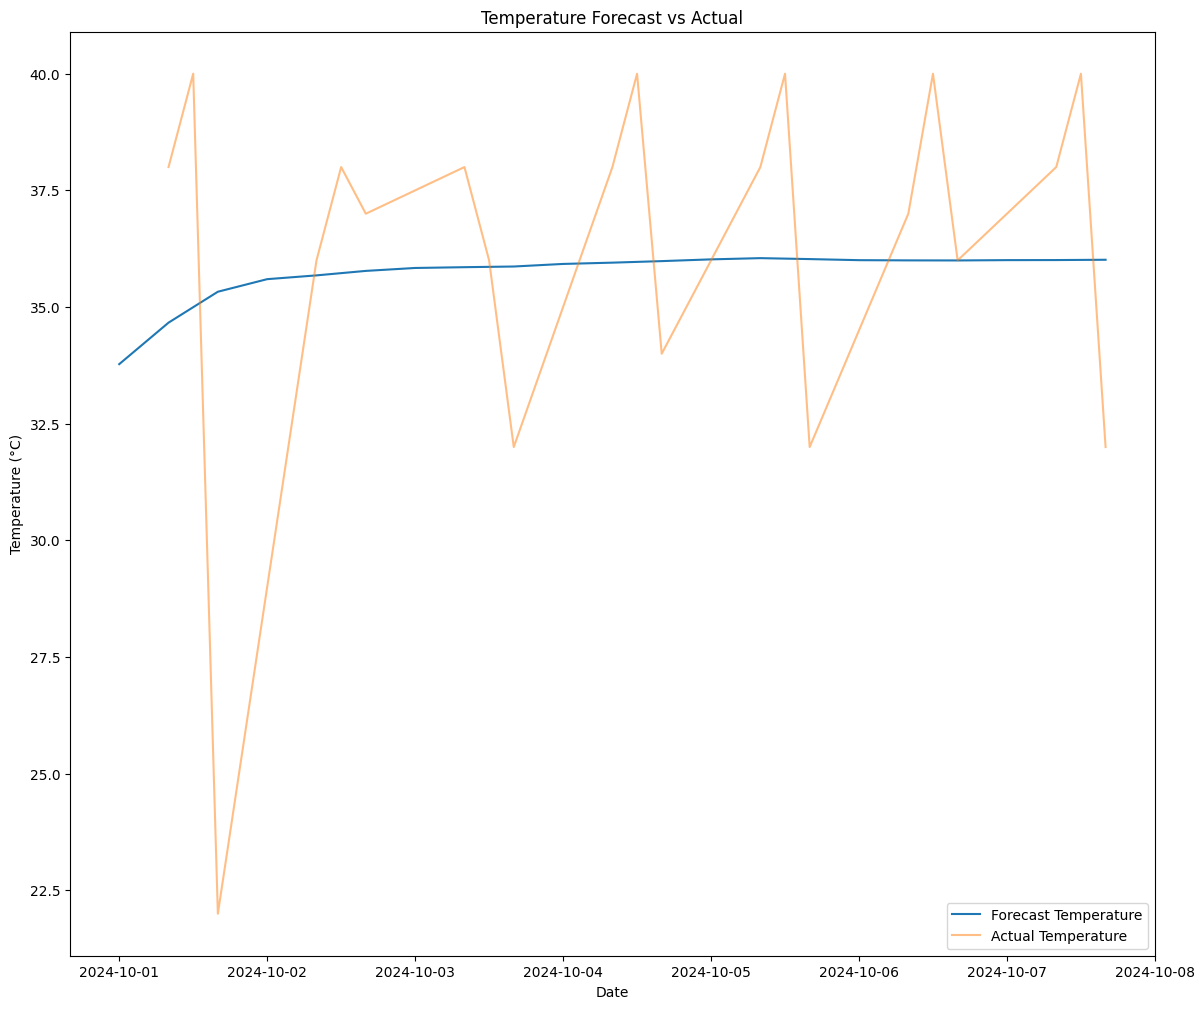

    TEMPERATURE (°C)  RAINFALL (mm)            DATETIME  ACTUAL CONDITION  \
0          33.776653       0.529246 2024-10-01 00:00:00                 4   
1          34.665783       0.327755 2024-10-01 08:00:00                 4   
2          35.328281       0.173200 2024-10-01 16:00:00                 5   
3          35.597767       0.106618 2024-10-02 00:00:00                 5   
4          35.678802       0.081484 2024-10-02 08:00:00                 5   
5          35.774780       0.054085 2024-10-02 16:00:00                 5   
6          35.837566       0.032171 2024-10-03 00:00:00                 5   
7          35.854301       0.025511 2024-10-03 08:00:00                 5   
8          35.868809       0.020196 2024-10-03 16:00:00                 5   
9          35.924000       0.002034 2024-10-04 00:00:00                 5   
10         35.951515      -0.007308 2024-10-04 08:00:00                 5   
11         35.984432      -0.017727 2024-10-04 16:00:00                 5   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

# Load dataset
data = pd.read_csv('Cleaned_MCS_TEAM_DATAX.csv')

# Convert 'DATETIME' to datetime object
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Sort dataset by date
data = data.sort_values(by='DATETIME')

# Identify numerical and categorical features
numerical_features = ['TEMPERATURE (°C)', 'RAINFALL (mm)']
categorical_features = ['ACTUAL CONDITION', 'OCCURENCE OF FLOOD']

# Convert categorical columns to category dtype
data[categorical_features] = data[categorical_features].astype('category')

# Handle categorical data: Encode categorical features
le_condition = LabelEncoder()
le_flood = LabelEncoder()
data['ACTUAL CONDITION'] = le_condition.fit_transform(data['ACTUAL CONDITION'])
data['OCCURENCE OF FLOOD'] = le_flood.fit_transform(data['OCCURENCE OF FLOOD'])

# Scale numerical features to the range [0, 1]
scaler = MinMaxScaler()
scaled_numerical_data = scaler.fit_transform(data[numerical_features])

# Combine scaled numerical data with encoded categorical data
scaled_data = np.hstack((scaled_numerical_data, data[categorical_features].values))

# Prepare time series data
look_back = 21  # Number of time steps to look back (7 days * 3 readings/day)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import KFold
import numpy as np

# Define look_back and batch size
look_back = 21
batch_size = 32

# Create TimeseriesGenerator for training data
generator = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=batch_size)

# Define function to build the GRU model
def build_gru_model(input_shape):
    model = Sequential()
    # First GRU layer with L2 regularization
    model.add(GRU(50, activation='tanh', return_sequences=True, 
                  input_shape=input_shape,
                  kernel_regularizer=l2(0.01)))  # L2 regularization added
    model.add(Dropout(0.3))
    # Second GRU layer
    model.add(GRU(20, activation='tanh', kernel_regularizer=l2(0.01)))  # L2 regularization added
    model.add(Dropout(0.3))
    # Output layer for multiple features
    model.add(Dense(len(numerical_features) + len(categorical_features)))  
    return model

# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 5
mae_scores = []
rmse_scores = []

for train_index, val_index in kfold.split(scaled_data):
    # Split data into training and validation sets
    train_data, val_data = scaled_data[train_index], scaled_data[val_index]
    
    # Create Timeseries Generators for train and validation
    train_generator = TimeseriesGenerator(train_data, train_data, length=look_back, batch_size=batch_size)
    val_generator = TimeseriesGenerator(val_data, val_data, length=look_back, batch_size=batch_size)
    
    # Build and compile the model
    model = build_gru_model((look_back, len(numerical_features) + len(categorical_features)))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    # Early Stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(train_generator,
                        epochs=20,
                        validation_data=val_generator,
                        callbacks=[early_stopping],
                        verbose=1)
    
    # Evaluate the model
    val_loss, val_mae = model.evaluate(val_generator)
    print(f"Fold {fold_no} - Validation MAE: {val_mae}")
    
    # Store the scores for later analysis
    mae_scores.append(val_mae)
    
    # Predict to calculate RMSE
    predictions = model.predict(val_generator)
    rmse = np.sqrt(np.mean((predictions - val_data[look_back:])**2))
    rmse_scores.append(rmse)
    
    fold_no += 1

# Print average performance across folds
print(f"\nAverage MAE across folds: {np.mean(mae_scores):.4f}")
print(f"Average RMSE across folds: {np.mean(rmse_scores):.4f}")

print(model.summary())

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae'])

# Train the model
model.fit(generator, epochs=50)

# Forecast the next 7 days (7 * 3 = 21 predictions)
n_future = 21  # Predicting 21 steps ahead (7 days of 3 readings per day)
last_data = scaled_data[-look_back:]  # Take the last 'look_back' period to predict

# Generate predictions for the next 7 days
forecast = []
input_seq = last_data.reshape((1, look_back, len(numerical_features) + len(categorical_features)))

for _ in range(n_future):
    prediction = model.predict(input_seq)
    forecast.append(prediction[0])
    # Update the input sequence with the new prediction
    input_seq = np.append(input_seq[:, 1:, :], [[prediction[0]]], axis=1)

# Convert forecast to a NumPy array
forecast = np.array(forecast)

# Convert forecast back to original scale for numerical features
forecast_numerical = scaler.inverse_transform(forecast[:, :len(numerical_features)])  # Only inverse scale numerical features

# Create a DataFrame for the forecasted data
forecast_dates = pd.date_range(start=data['DATETIME'].max() + pd.Timedelta(hours=8), periods=n_future, freq='8H')
forecast_df = pd.DataFrame(forecast_numerical, columns=numerical_features)
forecast_df['DATETIME'] = forecast_dates

# Add the predicted categorical values to the forecast DataFrame
# Assuming the last two columns of the prediction correspond to the categorical features
forecast_df['ACTUAL CONDITION'] = le_condition.inverse_transform(np.round(forecast[:, len(numerical_features)]).astype(int))
forecast_df['OCCURENCE OF FLOOD'] = le_flood.inverse_transform(np.round(forecast[:, len(numerical_features) + 1]).astype(int))

# Load actual data for comparison
actual_data = pd.read_csv('Actual.csv')
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Plotting the actual vs forecasted data
plt.figure(figsize=(14, 12))
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], label='Forecast Temperature')
plt.plot(actual_data['DATETIME'], actual_data['TEMPERATURE (°C)'], label='Actual Temperature', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Forecast vs Actual')
plt.show()

# Print the forecasted DataFrame
print(forecast_df)



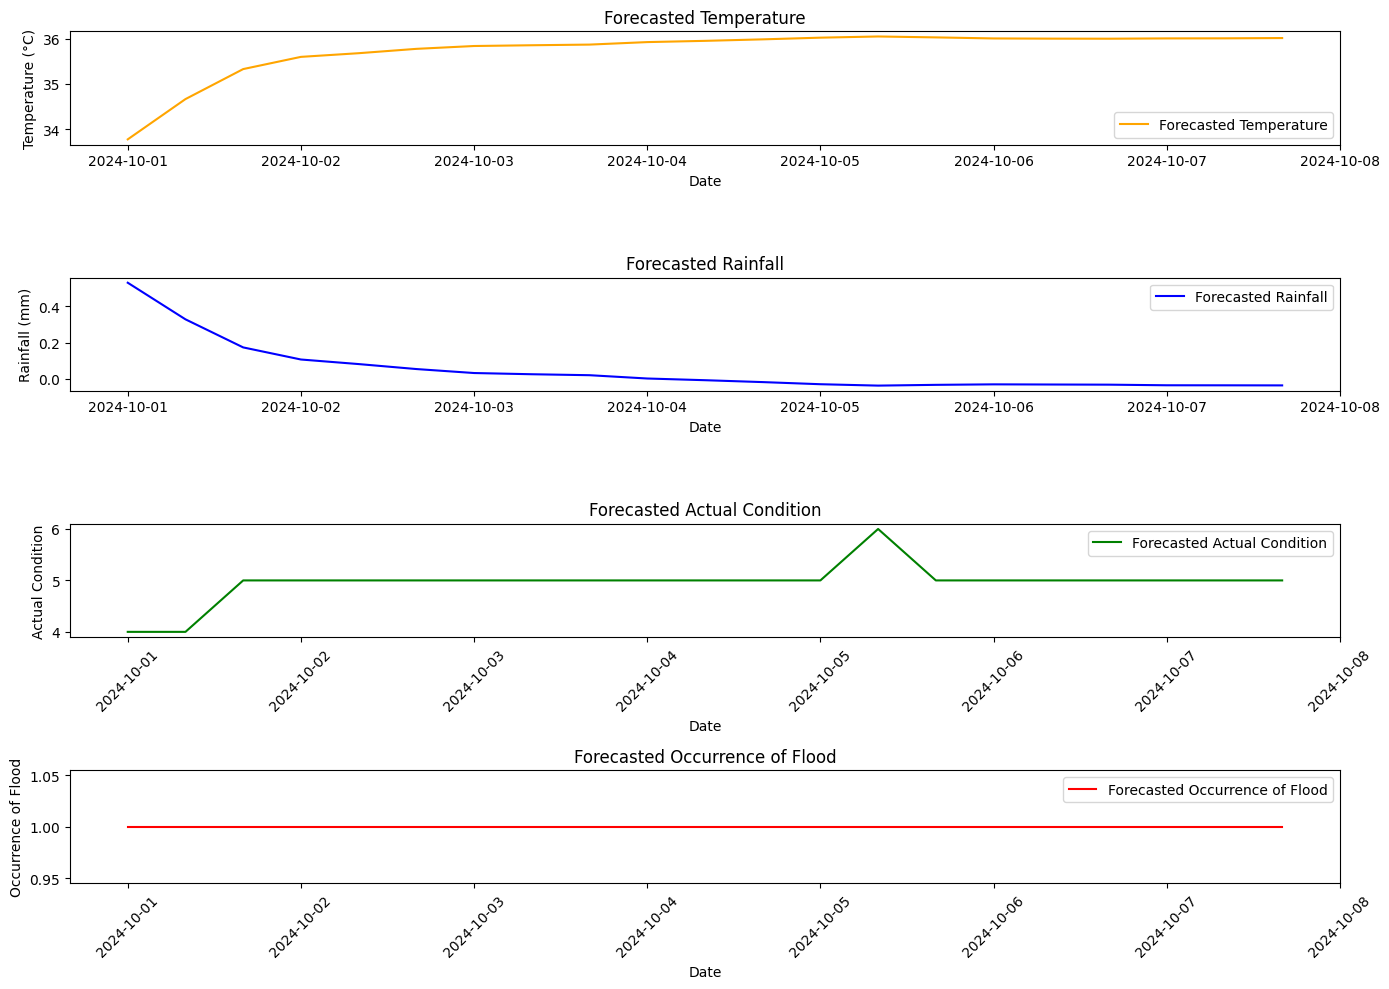

In [2]:
# Visualization of the results (optional)
plt.figure(figsize=(14, 10))

# Plot for Temperature
plt.subplot(4, 1, 1)
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Forecasted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot for Rainfall
plt.subplot(4, 1, 2)
plt.plot(forecast_df['DATETIME'], forecast_df['RAINFALL (mm)'], label='Forecasted Rainfall', color='blue')
plt.title('Forecasted Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()

# Plot for Actual Condition
plt.subplot(4, 1, 3)
plt.plot(forecast_df['DATETIME'], forecast_df['ACTUAL CONDITION'], label='Forecasted Actual Condition', color='green')
plt.title('Forecasted Actual Condition')
plt.xlabel('Date')
plt.ylabel('Actual Condition')
plt.xticks(rotation=45)
plt.legend()

# Plot for Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], label='Forecasted Occurrence of Flood', color='red')
plt.title('Forecasted Occurrence of Flood')
plt.xlabel('Date')
plt.ylabel('Occurrence of Flood')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

    TEMPERATURE (°C)  RAINFALL (mm)            DATETIME  ACTUAL CONDITION  \
0          33.776653       0.529246 2024-10-01 00:00:00                 4   
1          34.665783       0.327755 2024-10-01 08:00:00                 4   
2          35.328281       0.173200 2024-10-01 16:00:00                 5   
3          35.597767       0.106618 2024-10-02 00:00:00                 5   
4          35.678802       0.081484 2024-10-02 08:00:00                 5   
5          35.774780       0.054085 2024-10-02 16:00:00                 5   
6          35.837566       0.032171 2024-10-03 00:00:00                 5   
7          35.854301       0.025511 2024-10-03 08:00:00                 5   
8          35.868809       0.020196 2024-10-03 16:00:00                 5   
9          35.924000       0.002034 2024-10-04 00:00:00                 5   
10         35.951515      -0.007308 2024-10-04 08:00:00                 5   
11         35.984432      -0.017727 2024-10-04 16:00:00                 5   

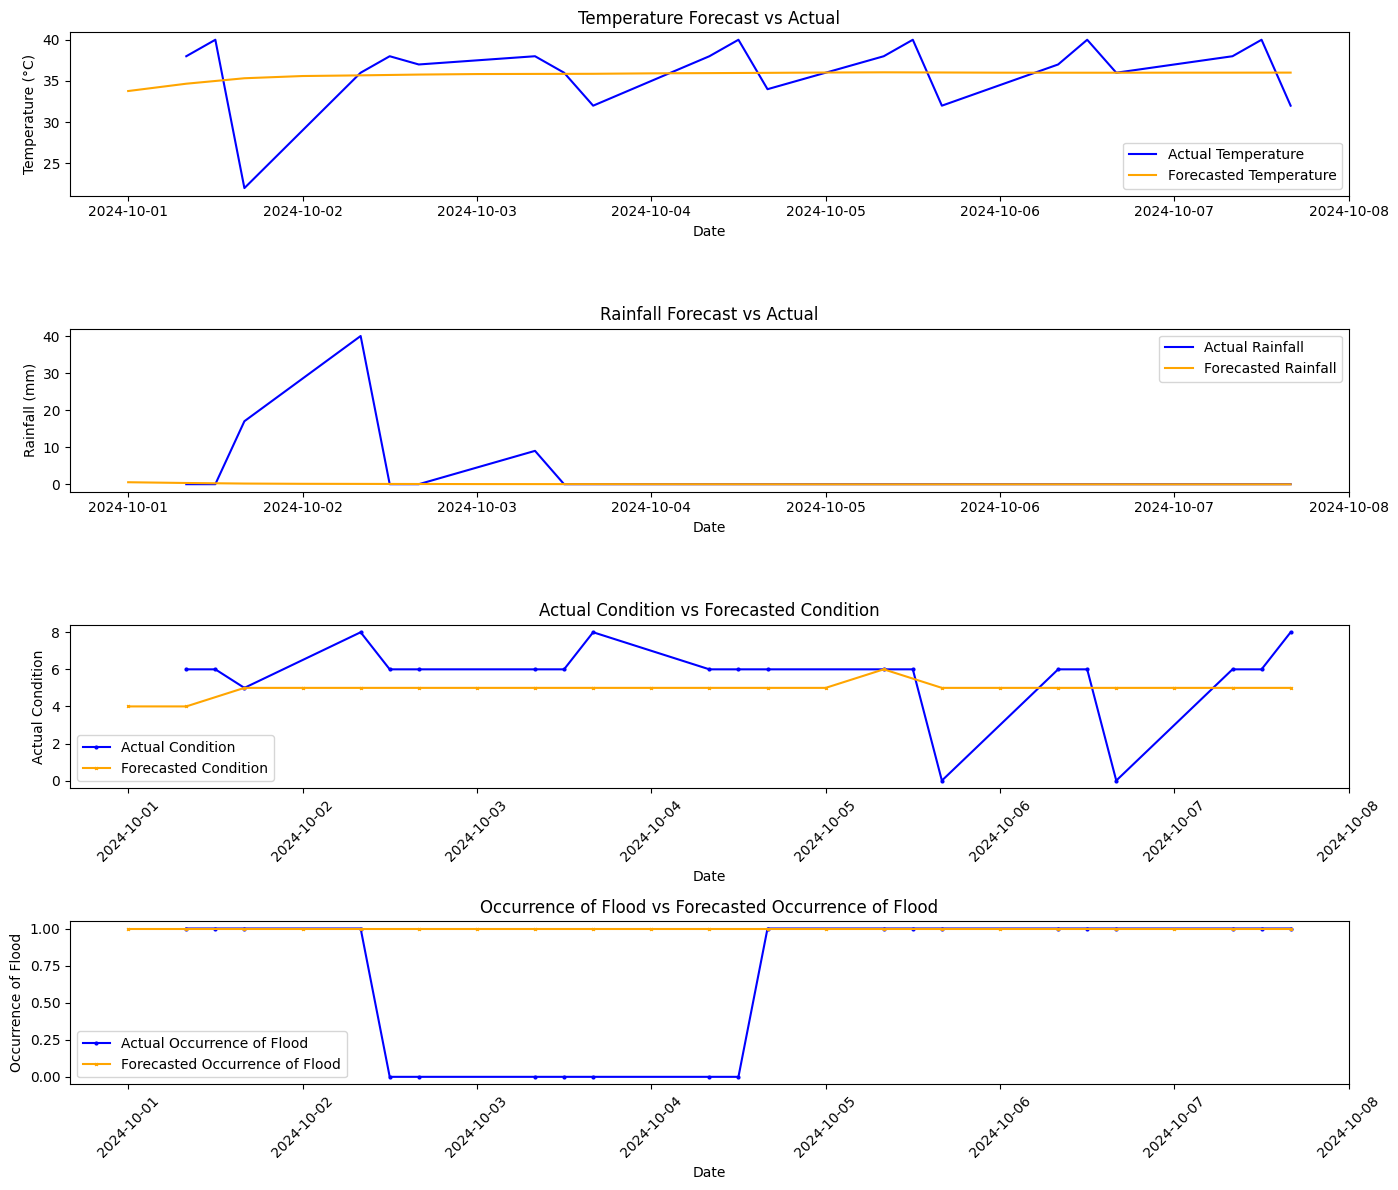

In [3]:
# Load actual data for comparison
actual_data = pd.read_csv('Actual.csv')
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Plotting the actual vs forecasted data
plt.figure(figsize=(14, 12))
print(forecast_df)
# Plot Temperature
plt.subplot(4, 1, 1)
plt.plot(actual_data['DATETIME'], actual_data['TEMPERATURE (°C)'], label='Actual Temperature', color='blue')
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Temperature Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot Rainfall
plt.subplot(4, 1, 2)
plt.plot(actual_data['DATETIME'], actual_data['RAINFALL (mm)'], label='Actual Rainfall', color='blue')
plt.plot(forecast_df['DATETIME'], forecast_df['RAINFALL (mm)'], label='Forecasted Rainfall', color='orange')
plt.title('Rainfall Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()

# Plot Actual Condition
plt.subplot(4, 1, 3)
plt.plot(actual_data['DATETIME'], actual_data['ACTUAL CONDITION'], label='Actual Condition', color='blue', marker='o', markersize=2)
plt.plot(forecast_df['DATETIME'], forecast_df['ACTUAL CONDITION'], label='Forecasted Condition', color='orange', marker='x', markersize=2)
plt.title('Actual Condition vs Forecasted Condition')
plt.xlabel('Date')
plt.ylabel('Actual Condition')
plt.xticks(rotation=45)
plt.legend()

# Plot Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(actual_data['DATETIME'], actual_data['OCCURENCE OF FLOOD'], label='Actual Occurrence of Flood', color='blue', marker='o', markersize=2)
plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], label='Forecasted Occurrence of Flood', color='orange', marker='x', markersize=2)
plt.title('Occurrence of Flood vs Forecasted Occurrence of Flood')
plt.xlabel('Date')
plt.ylabel('Occurrence of Flood')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
TEMPERATURE (°C) - MAE: 2.95, RMSE: 4.30
RAINFALL (mm) - MAE: 4.74, RMSE: 11.82
ACTUAL CONDITION - MAE: 1.93, RMSE: 2.49
OCCURENCE OF FLOOD - MAE: 0.29, RMSE: 0.53